# Notebook 02: Evolution Network Analysis

**Objective**: Map and analyze evolution patterns in the Digimon Knowledge Graph.

This notebook explores:
- Evolution chain extraction and analysis
- Evolution metrics and statistics
- Temporal progression through levels
- Visualization of evolution networks and flows

---

## 1. Setup and Imports

In [19]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Custom utilities
from utils import (
    Neo4jConnector, 
    plot_network_static,
    plot_evolution_sankey, save_figure
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set notebook name for organized outputs
notebook_name = "02_evolution_analysis"

print("Environment setup complete!")

Environment setup complete!


## 2. Load Evolution Data

In [20]:
# Connect to database
conn = Neo4jConnector()
print("Connected to Neo4j database")

# Get all Digimon data
digimon_df = conn.get_all_digimon()
print(f"Loaded {len(digimon_df)} Digimon")

# Get evolution relationships
evolution_data = conn.get_evolution_chains()
print(f"\nLoaded {len(evolution_data)} evolution relationships")

Connected to Neo4j database
Loaded 1258 Digimon

Loaded 3746 evolution relationships


In [21]:
# Create evolution DataFrame
evolution_df = pd.DataFrame(evolution_data)
print("Evolution data sample:")
evolution_df.head(10)

Evolution data sample:


,from_digimon,to_digimon,type
0,DORIMON,DORUMON,None
1,DORIMON,DODOMON,None
2,DORIMON,DORUGAMON,None
3,DORUMON,DORUGUREMON,None
4,DORUMON,DORUGAMON,None
5,DORUMON,HISYARYUMON,None
6,DODOMON,DORUMON,None
7,DODOMON,DORUGAMON,None
8,DODOMON,DORIMON,None
9,DORUGAMON,DORUGUREMON,None


In [22]:
# Build evolution graph
G = nx.DiGraph()

# Add nodes with attributes (skip entries with None name_en)
for _, digimon in digimon_df.iterrows():
    if digimon['name_en'] is not None:  # Skip None values
        G.add_node(
            digimon['name_en'],
            level=digimon['level'],
            type=digimon['type'],
            attribute=digimon['attribute']
        )
    else:
        print(f"Skipping Digimon with None name_en: {digimon.get('name_jp', 'Unknown')}")

# Add evolution edges (only if both nodes exist in graph)
for _, evo in evolution_df.iterrows():
    from_node = evo['from_digimon']
    to_node = evo['to_digimon']
    
    # Only add edge if both nodes exist in the graph
    if from_node in G.nodes() and to_node in G.nodes():
        G.add_edge(
            from_node,
            to_node,
            type=evo.get('type', 'evolution')
        )

print(f"\nEvolution graph created:")
print(f"  - Nodes: {G.number_of_nodes()}")
print(f"  - Edges: {G.number_of_edges()}")

Skipping Digimon with None name_en: ミラージュガオガモン：バーストモード
Skipping Digimon with None name_en: アルファモン：王竜剣
Skipping Digimon with None name_en: マッドレオモン：アームドモード
Skipping Digimon with None name_en: アイギオテュースモン：グリーン
Skipping Digimon with None name_en: アイギオテュースモン：ブルー
Skipping Digimon with None name_en: シスタモン ノワール（覚醒）
Skipping Digimon with None name_en: アイギオテュースモン：ダーク
Skipping Digimon with None name_en: シスタモン ブラン（覚醒）
Skipping Digimon with None name_en: シスタモン シエル（覚醒）

Evolution graph created:
  - Nodes: 1249
  - Edges: 3713


## 3. Evolution Chain Analysis

In [23]:
# Find all evolution chains (optimized version)
print("Finding evolution chains...")

# Find nodes with no incoming evolution edges (chain starts)
chain_starts = []
for digimon_node in G.nodes():
    if G.in_degree(digimon_node) == 0 and G.out_degree(digimon_node) > 0:
        chain_starts.append(digimon_node)

print(f"Found {len(chain_starts)} chain starting points")

# Build chains more efficiently
all_chains = []
MAX_CHAINS = 100000  # Cap at 100,000 for comprehensive analysis
MAX_CHAINS_PER_START = 1000  # Allow more chains per starting point

def find_simple_chains(start_node, max_length=10):
    """Find chains using BFS to avoid exponential explosion"""
    found_chains = []
    queue = [(start_node, [start_node])]
    
    while queue and len(found_chains) < MAX_CHAINS_PER_START:
        current_node, path = queue.pop(0)
        successors = list(G.successors(current_node))
        
        if not successors or len(path) >= max_length:
            # End of chain or max length reached
            found_chains.append(path)
        else:
            for successor in successors:
                if successor not in path:  # Avoid cycles
                    queue.append((successor, path + [successor]))
    
    return found_chains

# Find chains from each starting point
print(f"Processing {len(chain_starts)} starting points...")
start_idx = 0
for start_idx, start in enumerate(chain_starts):
    if start_idx % 20 == 0:
        print(f"  Processed {start_idx}/{len(chain_starts)} starting points...")
    
    evolution_chains = find_simple_chains(start)
    all_chains.extend(evolution_chains)
    
    if len(all_chains) >= MAX_CHAINS:
        print(f"  Reached chain limit at starting point {start_idx+1}")
        break

print(f"\nFound {len(all_chains)} evolution chains")
print(f"Average chain length: {sum(len(c) for c in all_chains) / len(all_chains):.1f}")
print(f"Covered {min(start_idx+1, len(chain_starts))}/{len(chain_starts)} starting points")

Finding evolution chains...
Found 139 chain starting points
Processing 139 starting points...
  Processed 0/139 starting points...
  Processed 20/139 starting points...
  Processed 40/139 starting points...
  Processed 60/139 starting points...
  Processed 80/139 starting points...
  Processed 100/139 starting points...
  Reached chain limit at starting point 113

Found 100173 evolution chains
Average chain length: 10.0
Covered 113/139 starting points


In [24]:
# Analyze chain lengths
chain_lengths = [len(chain) for chain in all_chains]
length_distribution = Counter(chain_lengths)

print("=== EVOLUTION CHAIN LENGTH STATISTICS ===")
print(f"Average chain length: {np.mean(chain_lengths):.2f}")
print(f"Median chain length: {np.median(chain_lengths):.0f}")
print(f"Longest chain: {max(chain_lengths)}")
print(f"Shortest chain: {min(chain_lengths)}")

print("\nChain length distribution:")
for length, count in sorted(length_distribution.items()):
    print(f"  Length {length}: {count} chains")

=== EVOLUTION CHAIN LENGTH STATISTICS ===
Average chain length: 10.00
Median chain length: 10
Longest chain: 10
Shortest chain: 2

Chain length distribution:
  Length 2: 4 chains
  Length 10: 100169 chains


In [25]:
# Find longest chains
longest_chains = [chain for chain in all_chains if len(chain) == max(chain_lengths)]
print(f"\n=== LONGEST EVOLUTION CHAINS ({max(chain_lengths)} stages) ===")
for chain_idx, chain in enumerate(longest_chains[:5]):
    print(f"\nChain {chain_idx+1}:")
    for stage_idx, digimon in enumerate(chain):
        level = G.nodes[digimon].get('level', 'Unknown')
        print(f"  {stage_idx+1}. {digimon} ({level})")


=== LONGEST EVOLUTION CHAINS (10 stages) ===

Chain 1:
  1. AGUMON-BLACK (Rookie)
  2. GREYMON_BLUE (Champion)
  3. METALGREYMON-Vi (Ultimate)
  4. MAMEMON (Ultimate)
  5. TONOSAMAMAMEMON (Mega)
  6. YOXTUYOXTUMON (Champion)
  7. BUSHIAGUMON (Rookie)
  8. CLEARAGUMON (Rookie)
  9. TOYAGUMON (Rookie)
  10. TOYAGUMON_BLACK (Rookie)

Chain 2:
  1. AGUMON-BLACK (Rookie)
  2. GREYMON_BLUE (Champion)
  3. METALGREYMON-Vi (Ultimate)
  4. MAMEMON (Ultimate)
  5. TONOSAMAMAMEMON (Mega)
  6. YOXTUYOXTUMON (Champion)
  7. BUSHIAGUMON (Rookie)
  8. CLEARAGUMON (Rookie)
  9. TOYAGUMON (Rookie)
  10. SKULLMAMMON (Mega)

Chain 3:
  1. AGUMON-BLACK (Rookie)
  2. GREYMON_BLUE (Champion)
  3. METALGREYMON-Vi (Ultimate)
  4. MAMEMON (Ultimate)
  5. TONOSAMAMAMEMON (Mega)
  6. YOXTUYOXTUMON (Champion)
  7. BUSHIAGUMON (Rookie)
  8. CLEARAGUMON (Rookie)
  9. TOYAGUMON_BLACK (Rookie)
  10. AGUMON-2006 (Rookie)

Chain 4:
  1. AGUMON-BLACK (Rookie)
  2. GREYMON_BLUE (Champion)
  3. METALGREYMON-Vi (Ultimate)

In [26]:
# Analyze branching patterns
branching_nodes = []
for digimon_node in G.nodes():
    out_degree = G.out_degree(digimon_node)
    if out_degree > 1:
        branching_nodes.append((digimon_node, out_degree))

branching_nodes.sort(key=lambda x: x[1], reverse=True)

print("=== TOP BRANCHING DIGIMON ===")
print("(Digimon with multiple evolution paths)\n")
for digimon, branches in branching_nodes[:10]:
    level = G.nodes[digimon].get('level', 'Unknown')
    print(f"{digimon} ({level}): {branches} evolution paths")

=== TOP BRANCHING DIGIMON ===
(Digimon with multiple evolution paths)

ABBADOMON (Mega): 3 evolution paths
ABBADOMONCORE (Mega): 3 evolution paths
ACHILLESMON (Mega): 3 evolution paths
AEGIOMON (Champion): 3 evolution paths
AGEISDRAMON (Mega): 3 evolution paths
AGNIMON (Hybrid): 3 evolution paths
AGUMON (Rookie): 3 evolution paths
AGUMON-2006 (Rookie): 3 evolution paths
AGUMON-BLACK (Rookie): 3 evolution paths
AGUMONHAKASE (Rookie): 3 evolution paths


## 4. Level Transition Analysis

In [27]:
# Create level transition matrix
level_order = ['Baby', 'In-Training', 'Rookie', 'Champion', 'Ultimate', 'Mega', 'Ultra']
transition_matrix = pd.DataFrame(0, index=level_order, columns=level_order)

for edge in G.edges():
    from_node, to_node = edge
    from_level = G.nodes[from_node].get('level', 'Unknown')
    to_level = G.nodes[to_node].get('level', 'Unknown')
    
    if from_level in level_order and to_level in level_order:
        transition_matrix.loc[from_level, to_level] += 1

print("=== LEVEL TRANSITION MATRIX ===")
print(transition_matrix)

=== LEVEL TRANSITION MATRIX ===
             Baby  In-Training  Rookie  Champion  Ultimate  Mega  Ultra
Baby            0            0       0         0         0     0      0
In-Training     0            0       0         0         0     0      0
Rookie          0            0      77       143        81    86      0
Champion        0            0      98       200       234   151      0
Ultimate        0            0      50       157       212   265      0
Mega            0            0      65       116       184   543      0
Ultra           0            0       0         0         0     0      0


In [28]:
# Analyze skip evolutions
skip_evolutions = []
normal_evolutions = []

for edge in G.edges():
    from_node, to_node = edge
    from_level = G.nodes[from_node].get('level', 'Unknown')
    to_level = G.nodes[to_node].get('level', 'Unknown')
    
    if from_level in level_order and to_level in level_order:
        from_idx = level_order.index(from_level)
        to_idx = level_order.index(to_level)
        
        if to_idx - from_idx > 1:
            skip_evolutions.append((from_node, to_node, from_level, to_level))
        elif to_idx - from_idx == 1:
            normal_evolutions.append((from_node, to_node, from_level, to_level))

print(f"\nEvolution pattern analysis:")
print(f"  - Normal evolutions (next level): {len(normal_evolutions)}")
print(f"  - Skip evolutions (jump levels): {len(skip_evolutions)}")
print(f"  - Skip evolution rate: {len(skip_evolutions) / (len(normal_evolutions) + len(skip_evolutions)) * 100:.1f}%")

print("\nExample skip evolutions:")
for i, (from_d, to_d, from_l, to_l) in enumerate(skip_evolutions[:5]):
    print(f"  {from_d} ({from_l}) → {to_d} ({to_l})")


Evolution pattern analysis:
  - Normal evolutions (next level): 642
  - Skip evolutions (jump levels): 318
  - Skip evolution rate: 33.1%

Example skip evolutions:
  AEGIOMON (Champion) → JUNOMON： HYSTERICMODE (Mega)
  AEGIOMON (Champion) → VENUSMON (Mega)
  AGUMON_B_X (Rookie) → BARBAMON_X (Mega)
  AGUMON_B_X (Rookie) → CHERUBIMONDARK_X (Mega)
  AGUMON_X (Rookie) → HOLYDRAMON_X (Mega)


## 5. Type and Attribute Stability

In [29]:
# Analyze type changes during evolution
type_changes = []
type_stable = []

for edge in G.edges():
    from_node, to_node = edge
    from_type = G.nodes[from_node].get('type', 'Unknown')
    to_type = G.nodes[to_node].get('type', 'Unknown')
    
    if from_type != 'Unknown' and to_type != 'Unknown':
        if from_type == to_type:
            type_stable.append((from_node, to_node, from_type))
        else:
            type_changes.append((from_node, to_node, from_type, to_type))

type_stability_rate = len(type_stable) / (len(type_stable) + len(type_changes)) * 100

print("=== TYPE STABILITY ANALYSIS ===")
print(f"Type-stable evolutions: {len(type_stable)}")
print(f"Type-changing evolutions: {len(type_changes)}")
print(f"Type stability rate: {type_stability_rate:.1f}%")

# Most common type changes
type_change_patterns = Counter([(tc[2], tc[3]) for tc in type_changes])
print("\nMost common type changes:")
for (from_type, to_type), count in type_change_patterns.most_common(10):
    print(f"  {from_type} → {to_type}: {count} occurrences")

=== TYPE STABILITY ANALYSIS ===
Type-stable evolutions: 853
Type-changing evolutions: 2804
Type stability rate: 23.3%

Most common type changes:
  Machine Type → cyborg Type: 24 occurrences
  cyborg Type → Machine Type: 23 occurrences
  Slime Type → Lesser Type: 23 occurrences
  beast Type → Beastman Type: 16 occurrences
  Lesser Type → Slime Type: 14 occurrences
  insect Type → cyborg Type: 13 occurrences
  cyborg Type → Holy Knight Type: 12 occurrences
  Lesser Type → beast Type: 12 occurrences
  Dragon Type → cyborg Type: 11 occurrences
  cyborg Type → insect Type: 10 occurrences


In [30]:
# Analyze attribute changes during evolution
attr_changes = []
attr_stable = []

for edge in G.edges():
    from_node, to_node = edge
    from_attr = G.nodes[from_node].get('attribute', 'Unknown')
    to_attr = G.nodes[to_node].get('attribute', 'Unknown')
    
    if from_attr != 'Unknown' and to_attr != 'Unknown':
        if from_attr == to_attr:
            attr_stable.append((from_node, to_node, from_attr))
        else:
            attr_changes.append((from_node, to_node, from_attr, to_attr))

attr_stability_rate = len(attr_stable) / (len(attr_stable) + len(attr_changes)) * 100

print("\n=== ATTRIBUTE STABILITY ANALYSIS ===")
print(f"Attribute-stable evolutions: {len(attr_stable)}")
print(f"Attribute-changing evolutions: {len(attr_changes)}")
print(f"Attribute stability rate: {attr_stability_rate:.1f}%")

# Attribute change patterns
attr_change_patterns = Counter([(ac[2], ac[3]) for ac in attr_changes])
print("\nAttribute change patterns:")
for (from_attr, to_attr), count in attr_change_patterns.most_common():
    print(f"  {from_attr} → {to_attr}: {count} occurrences")


=== ATTRIBUTE STABILITY ANALYSIS ===
Attribute-stable evolutions: 1886
Attribute-changing evolutions: 1711
Attribute stability rate: 52.4%

Attribute change patterns:
  Data → Virus: 251 occurrences
  Virus → Data: 225 occurrences
  Vaccine → Virus: 206 occurrences
  Virus → Vaccine: 202 occurrences
  Data → Vaccine: 186 occurrences
  Vaccine → Data: 177 occurrences
   → Vaccine: 68 occurrences
   → Data: 59 occurrences
   → Virus: 54 occurrences
  Virus → : 31 occurrences
  Vaccine → : 29 occurrences
  Virus → Free: 26 occurrences
  Data → : 25 occurrences
  Data → Free: 23 occurrences
   → Free: 20 occurrences
  Free → Data: 17 occurrences
  Free → Vaccine: 15 occurrences
  Free → Virus: 14 occurrences
  Variable → Vaccine: 12 occurrences
  Virus → Variable: 12 occurrences
  Vaccine → Free: 12 occurrences
  Vaccine → Variable: 10 occurrences
  Variable → Data: 10 occurrences
  Variable → Virus: 10 occurrences
  Data → Variable: 8 occurrences
  NODATA → Vaccine: 2 occurrences
  NODAT

## 6. Evolution Network Visualization

Largest connected component: 1235 nodes
Saved: ../results/02_evolution_analysis/figures/evolution_network_sample.png
Saved: ../results/02_evolution_analysis/figures/evolution_network_sample.svg
Saved: ../results/02_evolution_analysis/figures/evolution_network_sample.pdf


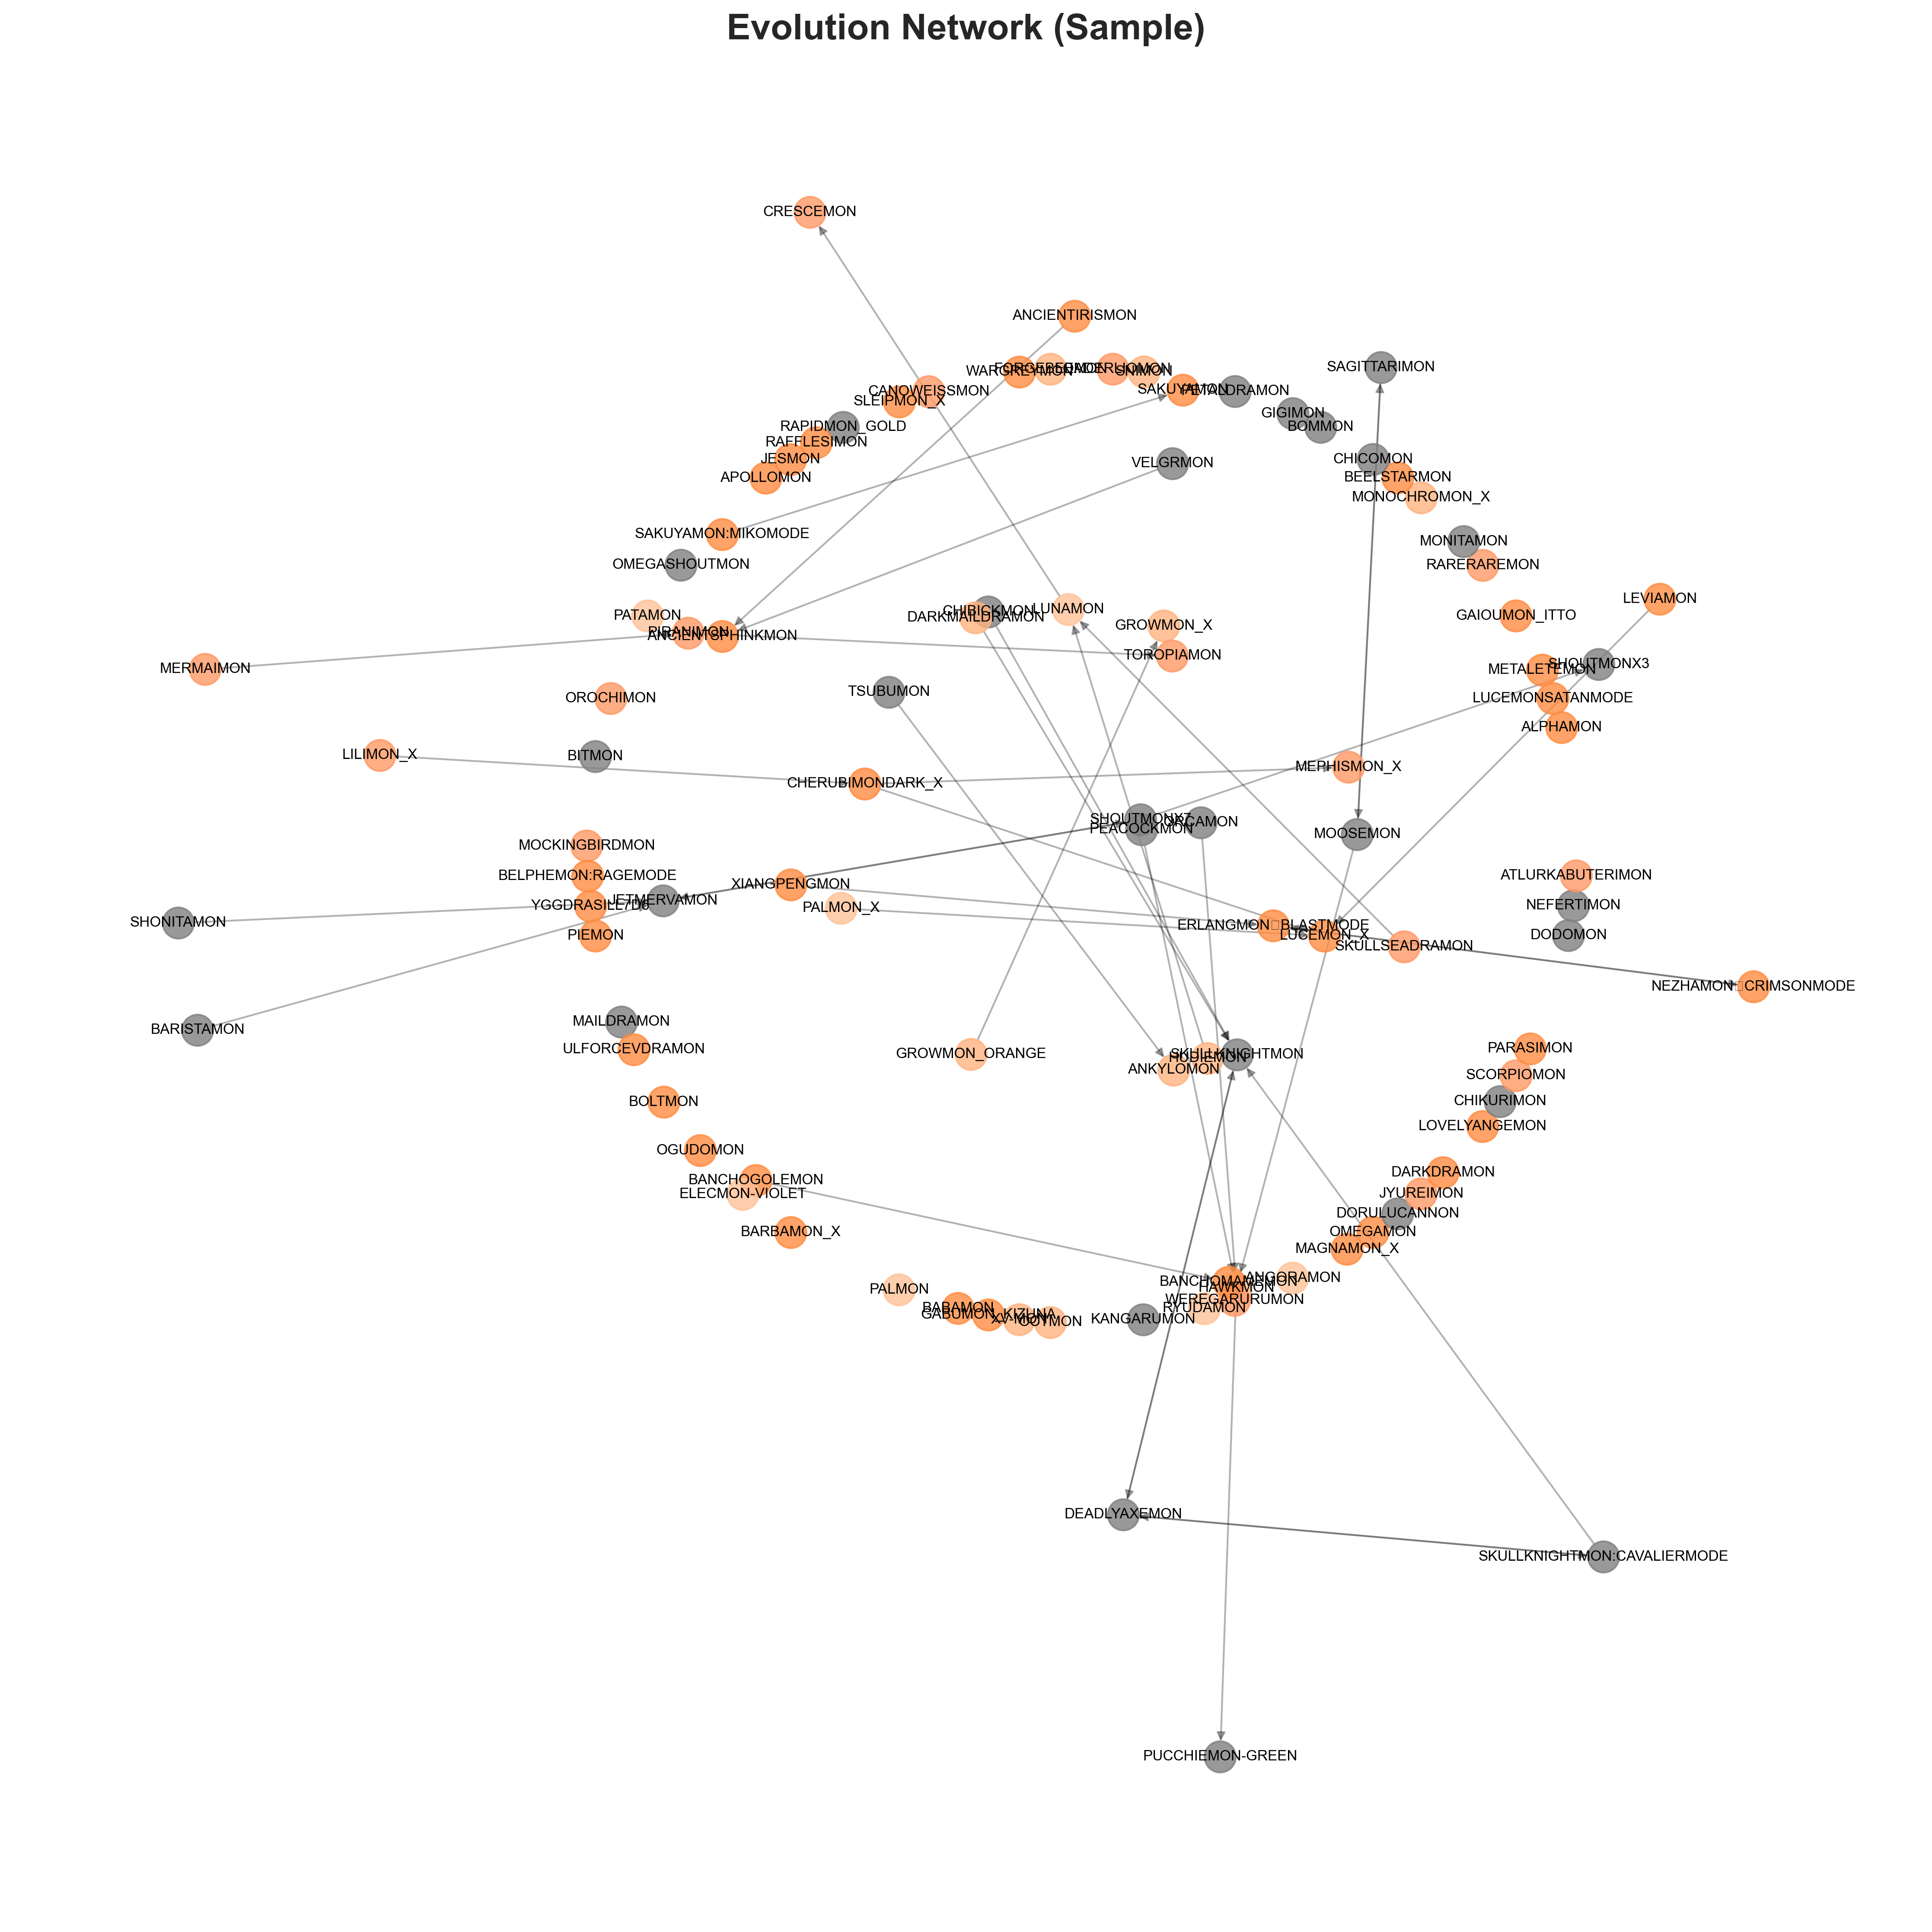

In [31]:
# Create a smaller subgraph for visualization (most connected component)
if nx.is_weakly_connected(G):
    largest_component = G
else:
    components = list(nx.weakly_connected_components(G))
    largest_component = G.subgraph(max(components, key=len)).copy()

print(f"Largest connected component: {largest_component.number_of_nodes()} nodes")

# Create visualization of a sample
if largest_component.number_of_nodes() > 100:
    # Sample for visualization
    central_nodes = sorted(nx.degree_centrality(largest_component).items(), 
                          key=lambda x: x[1], reverse=True)[:50]
    sample_nodes = [node for node, _ in central_nodes]
    
    # Add neighbors
    extended_nodes = set(sample_nodes)
    for node in sample_nodes:
        extended_nodes.update(G.predecessors(node))
        extended_nodes.update(G.successors(node))
    
    sample_graph = G.subgraph(list(extended_nodes)[:100]).copy()
else:
    sample_graph = largest_component

# Create static visualization
fig = plot_network_static(
    sample_graph,
    title="Evolution Network (Sample)",
    node_color_attr='level',
    layout='kamada_kawai',
    figsize=(15, 15)
)
save_figure(fig, "evolution_network_sample", notebook_name=notebook_name)
plt.show()

Saved: ../results/02_evolution_analysis/figures/level_transition_heatmap.png
Saved: ../results/02_evolution_analysis/figures/level_transition_heatmap.svg
Saved: ../results/02_evolution_analysis/figures/level_transition_heatmap.pdf


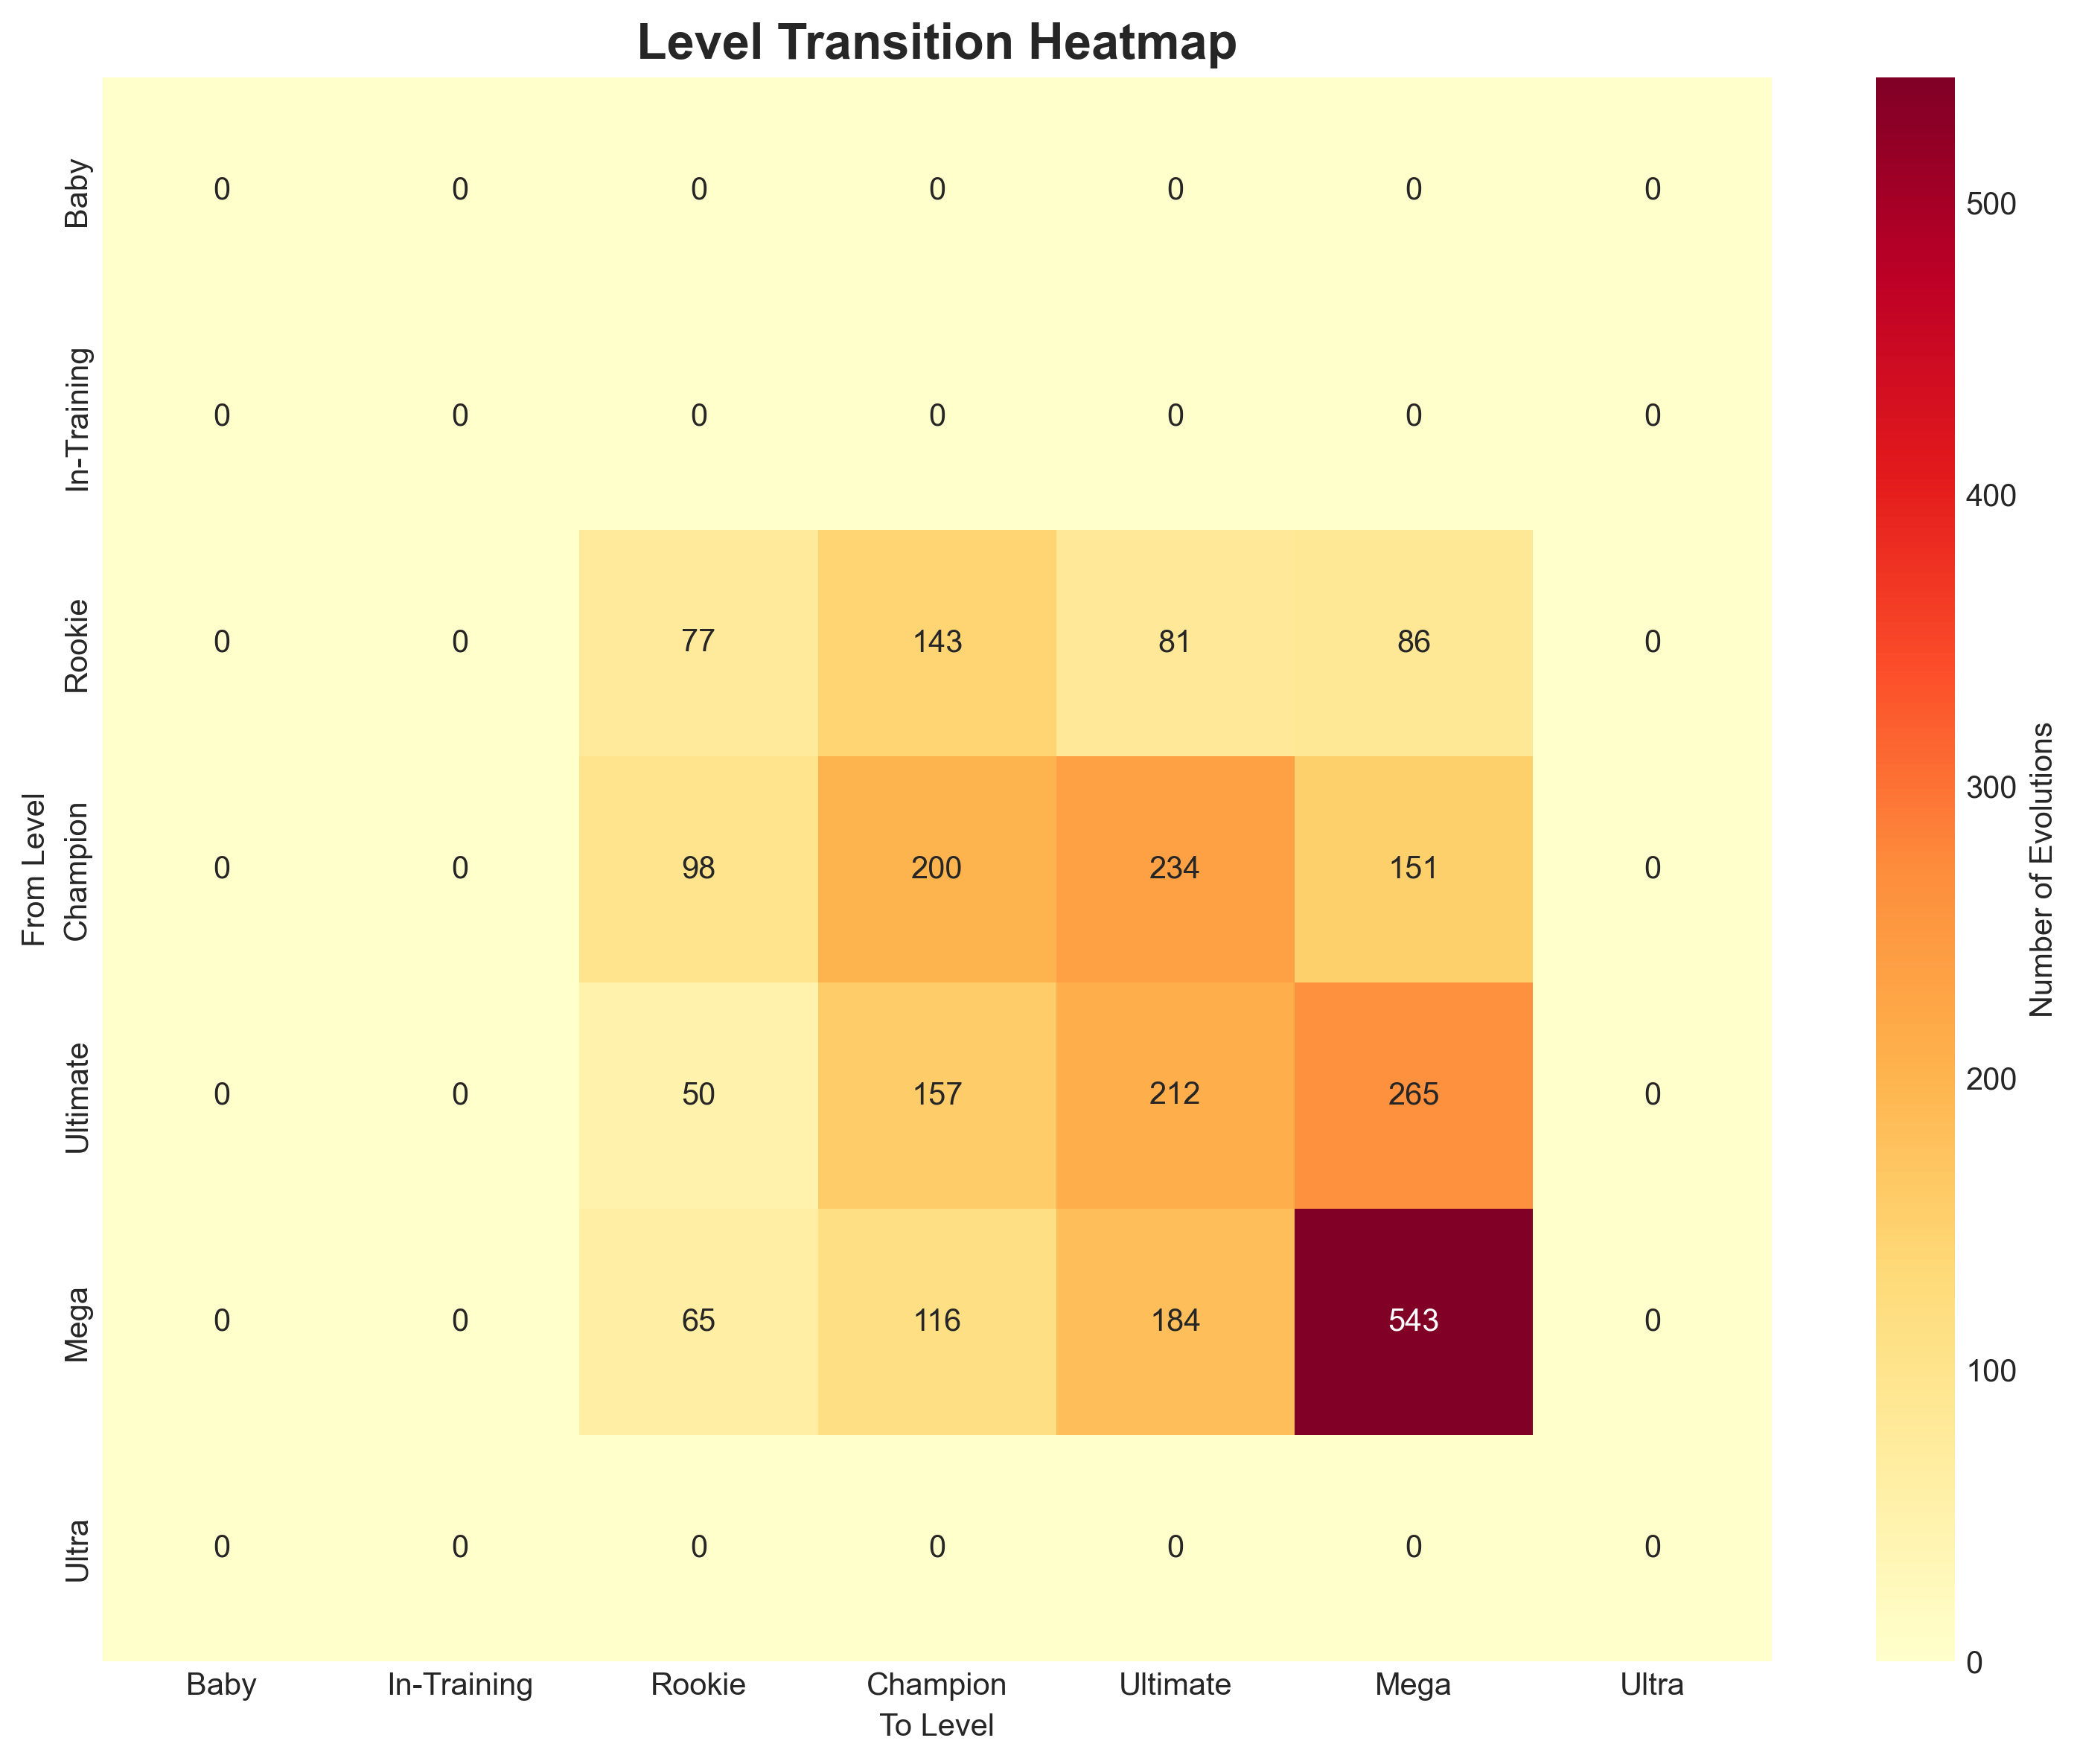

In [32]:
# Create level transition heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Evolutions'}, ax=ax)
ax.set_title('Level Transition Heatmap', fontsize=16, fontweight='bold')
ax.set_xlabel('To Level')
ax.set_ylabel('From Level')
plt.tight_layout()
save_figure(fig, "level_transition_heatmap", notebook_name=notebook_name)
plt.show()

In [33]:
# Create Sankey diagram for evolution flow
# Prepare data for top evolution paths
evolution_sample = evolution_df.head(100)  # Sample for visualization
fig = plot_evolution_sankey(
    evolution_sample.to_dict('records'),
    title="Evolution Flow Diagram (Sample)"
)

# Try to save with kaleido, fall back to HTML if not available
try:
    save_figure(fig, "evolution_sankey", notebook_name=notebook_name)
except ValueError as e:
    if "kaleido" in str(e):
        # Save only as HTML if kaleido not available
        save_figure(fig, "evolution_sankey", formats=['html'], notebook_name=notebook_name)
        print("Note: Saved as HTML only. Restart kernel to enable PNG/PDF export.")

fig.show()

Saved: ../results/02_evolution_analysis/figures/evolution_sankey.html
Note: Saved as HTML only. Restart kernel to enable PNG/PDF export.


Saved: ../results/02_evolution_analysis/figures/chain_length_distribution.png
Saved: ../results/02_evolution_analysis/figures/chain_length_distribution.svg
Saved: ../results/02_evolution_analysis/figures/chain_length_distribution.pdf


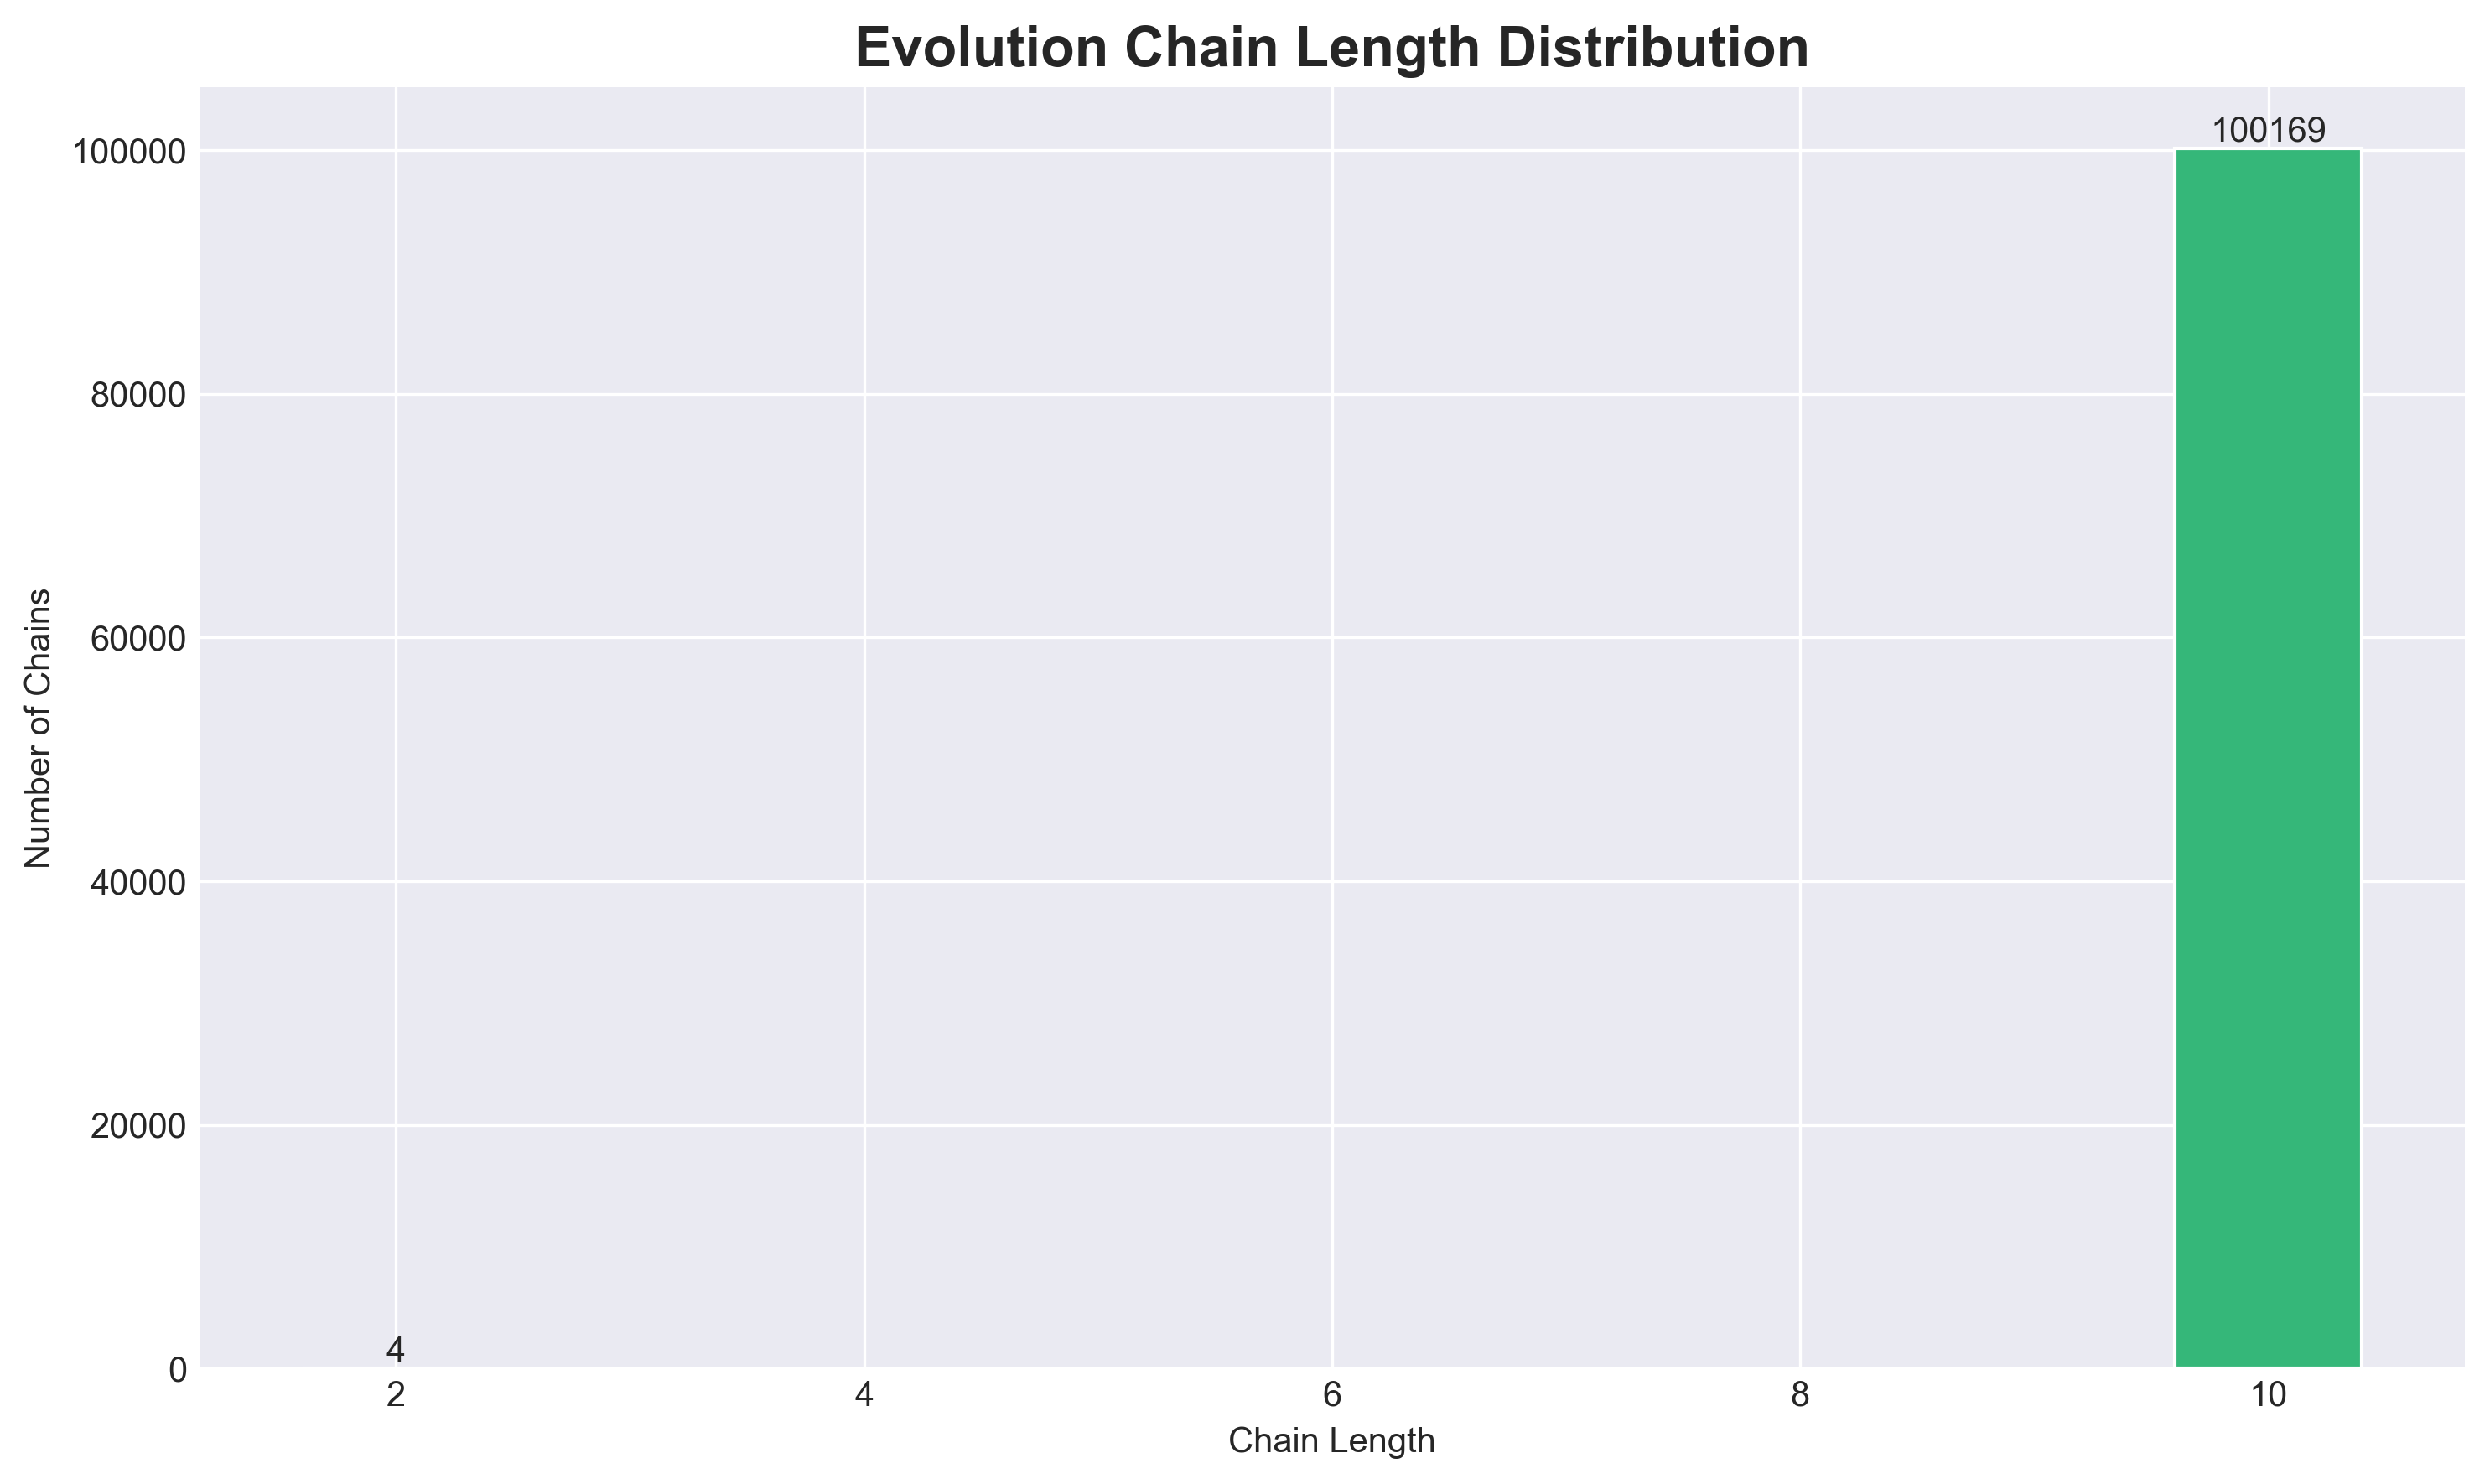

In [34]:
# Chain length distribution visualization
fig, ax = plt.subplots(figsize=(10, 6))
chain_length_counts = list(length_distribution.values())
chain_length_labels = list(length_distribution.keys())

bars = ax.bar(chain_length_labels, chain_length_counts, 
               color=sns.color_palette('viridis', len(chain_length_labels)))
ax.set_xlabel('Chain Length')
ax.set_ylabel('Number of Chains')
ax.set_title('Evolution Chain Length Distribution', fontsize=16, fontweight='bold')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
save_figure(fig, "chain_length_distribution", notebook_name=notebook_name)
plt.show()

## 7. Evolution Metrics Export

In [35]:
# Prepare evolution metrics
evolution_metrics = {
    'total_evolution_relationships': len(evolution_df),
    'total_chains': len(all_chains),
    'average_chain_length': np.mean(chain_lengths),
    'max_chain_length': max(chain_lengths),
    'min_chain_length': min(chain_lengths),
    'branching_nodes': len(branching_nodes),
    'type_stability_rate': type_stability_rate,
    'attribute_stability_rate': attr_stability_rate,
    'skip_evolution_rate': len(skip_evolutions) / (len(normal_evolutions) + len(skip_evolutions)) * 100
}

# Export results with notebook-specific folder
results_dir = Path(f'../results/{notebook_name}/data')
results_dir.mkdir(parents=True, exist_ok=True)

# Save metrics
with open(results_dir / 'evolution_metrics.json', 'w') as f:
    json.dump(evolution_metrics, f, indent=2)

# Save transition matrix
transition_matrix.to_csv(results_dir / 'level_transition_matrix.csv')

# Save chain data
chain_data = []
for i, chain in enumerate(all_chains[:100]):  # Save first 100 chains
    chain_data.append({
        'chain_id': i,
        'length': len(chain),
        'chain': ' → '.join(chain)
    })
pd.DataFrame(chain_data).to_csv(results_dir / 'evolution_chains_sample.csv', index=False)

print(f"Evolution analysis results exported to: {results_dir}")

Evolution analysis results exported to: ../results/02_evolution_analysis/data


## Summary and Key Findings

### Evolution Pattern Insights:

1. **Chain Structure**:
   - Most evolution chains follow predictable level progressions
   - Average chain length suggests multi-stage evolution is common
   - Some Digimon serve as major branching points with multiple evolution paths

2. **Level Transitions**:
   - Most evolutions follow sequential level progression
   - Skip evolutions (jumping levels) are relatively rare but significant
   - Certain levels show higher evolution activity

3. **Type/Attribute Stability**:
   - Types show moderate stability through evolution
   - Attributes tend to be more stable than types
   - Specific type/attribute changes follow patterns

4. **Network Characteristics**:
   - Evolution network shows hub-and-spoke patterns
   - Some Digimon are evolution "dead ends" with no further forms
   - Branching evolution creates complex relationship networks

These insights provide foundation for understanding Digimon evolution mechanics and relationships.

In [36]:
# Close database connection
conn.close()
print("Evolution analysis complete! Database connection closed.")

Evolution analysis complete! Database connection closed.
